In [1]:
import pandas as pd
import datetime
import numpy as np
import os.path
import wget
from zipfile import ZipFile
import shutil
import re
from multiprocessing import Pool
import multiprocessing as mp
import yfinance as yf

In [2]:
## Variaveis globais

#Pega data corrente e ano corrente se quiser fazer backtest acho que é só editar o date
date = datetime.date.today()
year = date.year

# ano inicial pra coleta dos dados
year_0 = 2010 
year_0_tri = year-2 # ano inicial pra coletoa dos dados trimestrais

# volume minimo pra pegar cotacao
vol_minimo = 1000

In [3]:
# baixa todos os dados se não estiverem presentes, retorna uma lista de nomes de arquivos baixados
def baixa_dados(year_0=year_0, year=year, year_0_tri=year_0_tri):
    # URL's onde estão os arquivos dfp e itr na CVM
    url_base = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/'
    url_base_fre = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/FRE/DADOS/'
    url_base_tri = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/'
    url_base_fca = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/FCA/DADOS/"

    # Cria uma lista com os nomes dos arquivos de dados anuais (dfp) da CVM
    arquivos_zip = []
    for ano in range(year_0, year + 1):
        arquivos_zip.append(f'dfp_cia_aberta_{ano}.zip')

    # baixa os arquivos dfp
    arquivos_zip_dfp_baixados = []
    for arq in arquivos_zip:
        if (os.path.isfile(f'./Data/{arq}')):
            print('%s já esta aqui' % arq)
            arquivos_zip_dfp_baixados.append(arq)
        else:
            try:
                wget.download(url_base + arq, out=f"./Data/{arq}")
                arquivos_zip_dfp_baixados.append(arq)
            except:
                print(f"falha ao baixar {arq}")
                pass

    # Cria lista de arquivos ITR (trimestrais) pra baixar
    arquivos_zip = []
    for ano in range(year_0_tri, year + 1):
        arquivos_zip.append(f'itr_cia_aberta_{ano}.zip')

    # baixa os arquivos ITR (dados trimestrais) se não estiverem presentes
    arquivos_zip_itr_baixados = []
    for arq in arquivos_zip:
        if (os.path.isfile(f'./Data/{arq}')):
            print('%s já esta aqui' % arq)
            arquivos_zip_itr_baixados.append(arq)
        else:
            try:
                wget.download(url_base_tri + arq, out=f"./Data/{arq}")
                arquivos_zip_itr_baixados.append(arq)
            except:
                print(f"falha ao baixar {arq}")
                pass

    # baixa arquivo FCA, que contém os tickers

    # Cria lista de arquivos FCA  pra baixar. Este aqui só precisa baixar o do último ano disponível
    # Se não tiver do ano atual baixa o do ano passado
    arquivos_zip = []
    for ano in [year, year - 1]:
        arquivos_zip.append(f'fca_cia_aberta_{ano}.zip')

    arquivos_zip_fca_baixados = []
    for arq in arquivos_zip:
        if (os.path.isfile(f'./Data/{arq}')):
            print('%s já esta aqui' % arq)
            arquivos_zip_fca_baixados.append(arq)
            break
        else:
            try:
                wget.download(url_base_fca + arq, out=f"./Data/{arq}")
                arquivos_zip_fca_baixados.append(arq)
                break # se conseguiu baixar 1 já sai do loop
            except:
                print(f"falha ao baixar {arq}")
    
    # baixa arquivo FRE, que contém o número total de ações
    
    arquivos_zip = []
    for ano in range(year-3, year+1):
        arquivos_zip.append(f'fre_cia_aberta_{ano}.zip')

    arquivos_zip_fre_baixados = []
    for arq in arquivos_zip:
        if (os.path.isfile(f'./Data/{arq}')):
            print('%s já esta aqui' % arq)
            arquivos_zip_fre_baixados.append(arq)
        else:
            try:
                wget.download(url_base_fre + arq, out=f"./Data/{arq}")
                arquivos_zip_fre_baixados.append(arq)
            except:
                print(f"falha ao baixar {arq}")
                
    return (arquivos_zip_dfp_baixados, arquivos_zip_itr_baixados, arquivos_zip_fca_baixados, arquivos_zip_fre_baixados)

In [4]:
def processa_dados(year_0=year_0, year=year, year_0_tri=year_0_tri):
    print("Processando dados")
    
    # DFP - Dados anuais
    # junta todos os anos de dados anuais em um arquivo só de cada tipo
    nomes = ['BPA_con', 'BPA_ind', 'BPP_con', 'BPP_ind', 'DRE_con', 'DRE_ind',
             'DFC_MD_con', 'DFC_MI_con', 'DFC_MD_ind', 'DFC_MI_ind']
    for nome in nomes:
        arquivo_bp = pd.DataFrame()
        for ano in range(year_0, year):
            try:
                arquivo_bp = pd.concat([arquivo_bp,
                                        pd.read_csv(f'./Data/temp/dfp_cia_aberta_{nome}_{ano}.csv', sep=';',
                                                    decimal=',', encoding='ISO-8859-1')])
            except:
                print(f"falha em {nome}")
                pass
        arquivo_bp.to_csv(f'./Data/processados/dfp_cia_aberta_{nome}_{year_0}-{year}.csv', index=False, encoding="latin1")
        print(f'DFP {nome} processado')
    
    # ITR - Dados trimestrais
    # junta todos os anos de dados trimestrais em um arquivo só de cada tipo
    nomes_tri = ['BPA_con', 'BPA_ind', 'BPP_con', 'BPP_ind', 'DRE_con', 'DRE_ind',
                 "DFC_MD_con", "DFC_MI_con", "DFC_MD_ind", "DFC_MI_ind"]
    for nome in nomes_tri:
        arquivo_bp = pd.DataFrame()
        for ano in range(year_0_tri, year + 1):
            try:
                arquivo_bp = pd.concat([arquivo_bp,
                                        pd.read_csv(f'./Data/temp/itr_cia_aberta_{nome}_{ano}.csv', sep=';',
                                                    decimal=',', encoding='ISO-8859-1')])
            except:
                print(f"falha em itr_cia_aberta_{nome}_{ano}")
                pass
        arquivo_bp.to_csv(f'./Data/processados/itr_cia_aberta_{nome}_{year_0_tri}-{year}.csv', index=False, encoding="latin1")
        print(f'ITR {nome} processado')
    
    # FRE - Contém q qtd de ações das empresas
    
    # cria uma lista com todos os arquivos fre
    arq_fre = [item for item in os.listdir("./Data/temp") if item.startswith("fre_cia_aberta_distribuicao_capital_2")]
    fre = pd.DataFrame()

    # concatena tudo
    for arq in arq_fre[::-1]:
        fre = pd.concat([fre, pd.read_csv(f"./Data/temp/{arq}", sep=";")], axis=0)

    # joga fora as linhas com 0
    fre = fre[fre["Quantidade_Total_Acoes_Circulacao"] != 0]

    # ordena pelo mais recente, retira as duplicatas e pega só as colunas que interessam
    fre = fre.sort_values(by=["Data_Referencia", "Versao"], ascending=False).drop_duplicates(["CNPJ_Companhia"], keep="first")[["CNPJ_Companhia", "Quantidade_Total_Acoes_Circulacao"]]

    # salva em um csv
    fre.to_csv("./Data/processados/qtd_acoes.csv", encoding="latin1", index=False)
    #fre.set_index("CNPJ_Companhia", inplace=True)
    print("FRE processado")
    
    # arquivo FCA - Contém tickers das empresas
    
    # pega o nome do arquivo fca que contem os tickers
    arq_fca = [item for item in os.listdir("./Data/temp") if item.startswith("fca_cia_aberta_valor_mobiliario")]
    arq_fca = arq_fca[0]

    # copia o arquivo fca pra pasta processados
    shutil.copyfile(f"./Data/temp/{arq_fca}", f"./Data/processados/fca.csv")
    print("FCA processado")
        
    print("Arquivos processados")

In [5]:
# só extrai o arquivo dado como parâmetro para a pasta ./Data/temp
def extrai_arquivo(arq):
    try:
        ZipFile(f"./Data/{arq}", 'r').extractall('./Data/temp')
        print(f"{arq} extraido")
    except:
        print(f"erro ao extrair {arq}")

# extrai uma lista de arquivos com paralelismo. não roda no jupyter

def extrai_paralelo(arquivos_para_extrair):

    #  descobre quantas threads tem o CPU atual e cria uma pool para extrair os dados com paralelismo
    procs = mp.cpu_count()
    pool = Pool(procs)

    # cria uma lista de pools para depois dar get
    lista_pool = []
    for arq in arquivos_para_extrair:
        lista_pool.append(pool.apply_async(extrai_arquivo, args=(arq,)))
    print("Extraindo")
    output = [item.get() for item in lista_pool]
    return(output)

In [6]:
# faz o usuario escolher uma empresa
def escolhe_empresa(lista_empresas):
    while True:
        busca = input("Entre com o ticker da empresa sem o número: ")
        empresa = lista_empresas[lista_empresas['TICKER'].str.contains(busca, case=False)]
        print(empresa[["DENOM_CIA", "CD_CVM", "TICKER"]])
        ok = input("A empresa desejada está na primeira linha? (y/n) ")
        if ok == "y":
            return(empresa)

In [7]:
# retorna um df com CNPJ razao social e ticker de todas as empresas listadas em bolsa
def cria_lista_empresas(year_0=year_0, year=year, year_0_tri=year_0_tri):

    #cria lista de empresas. Concatena consolidado e individual
    lista_empresas = pd.read_csv(f"./Data/processados/dfp_cia_aberta_BPA_con_{year_0}-{year}.csv", header=0, sep=",", encoding="latin1")[["DENOM_CIA", 'CD_CVM', "CNPJ_CIA"]].drop_duplicates()
    lista_empresas["tipo"] = "con"
    ind = pd.read_csv(f"./Data/processados/dfp_cia_aberta_BPA_ind_{year_0}-{year}.csv", header=0, sep=",", encoding="latin1")[["DENOM_CIA", 'CD_CVM', "CNPJ_CIA"]].drop_duplicates()
    ind["tipo"] = "ind"
    lista_empresas = pd.concat([lista_empresas, ind], ignore_index=True).drop_duplicates(keep="first")
    lista_empresas.set_index("CNPJ_CIA", inplace=True)

    # coloca tickers do arquivo fca
    lista_empresas = lista_empresas.join(pd.read_csv(f"./Data/processados/fca.csv", header=0, sep=";", encoding="latin1").set_index("CNPJ_Companhia")["Codigo_Negociacao"].dropna())

    # pega tickers da B3 tbm pq na CVM é incompleto.
    # extraí de https://www.b3.com.br/pt_br/produtos-e-servicos/negociacao/renda-variavel/empresas-listadas.htm
    # no futuro seria bom automatizar isso com um webscraper
    b3 = pd.read_csv("./Data/empresas_listadas_b3.csv", encoding="latin1", sep=";")[["Razão Social","Código"]]

    # Cria a coluna CNPJ com os dados do index
    lista_empresas = lista_empresas.rename_axis('CNPJ').reset_index()

    # Junta os dados da b3 no arquivo original
    lista_empresas = lista_empresas.merge(b3, left_on="DENOM_CIA", right_on="Razão Social", how="left").drop(columns=["Razão Social"])
    
    # Dá replace em todas as linhas de "Codigo_Negociacao" que não obedecem o padrão "ABCD1" ou "ABCD11"
    lista_empresas["Codigo_Negociacao"].replace(to_replace= r"^(?!\D{4}\d{1,2}$).*", value= np.nan, regex=True, inplace=True)

    # Pega só as 4 primeiras letras da coluna "Codigo_Negociacao"
    lista_empresas["TICKER"] = lista_empresas["Codigo_Negociacao"].str[:4]
    lista_empresas.drop(columns=["Codigo_Negociacao"], inplace=True)
    lista_empresas.drop_duplicates(inplace=True)

    # Dá replace nos NaN da CVM com o ticker do site da B3
    lista_empresas["TICKER"].fillna(lista_empresas["Código"], inplace=True)

    # Joga fora a coluna com tickers da B3
    lista_empresas.drop(columns=["Código"], inplace=True)
    
    # joga fora o que não tiver ticker
    lista_empresas.dropna(inplace=True)
    
    #deixa o index como o CNPJ
    lista_empresas.set_index("CNPJ")
    
    # tira linhas duplicadas (tem que ter CNPJ, CD_CVM e TICKER iguais)
    lista_empresas.drop_duplicates(["CNPJ", "CD_CVM", "TICKER"], inplace=True)
    
    # muda o index pro CNPJ pra poder dar join
    lista_empresas.set_index("CNPJ", inplace=True)

    # pega a quantidade de ações em circulação e tira as empresas que não tem nenhuma. isso já limpa bem os dados
    fre = pd.read_csv("./Data/processados/qtd_acoes.csv").set_index("CNPJ_Companhia")
    lista_empresas = lista_empresas.join(fre).dropna()
    
    #salva em um csv
    lista_empresas.to_csv("./Data/processados/lista empresas.csv", encoding="latin1", index=False)
    
    return(lista_empresas)

In [8]:
# funcao colocar lucros ultimos 10 anos na lista_empresas e calcular indicadores
def Coloca_lucro(lista_empresas, dropa_tri=True, year_0=year_0, year=year, year_0_tri=year_0_tri):
    for tipo in ["con", "ind"]:
        dre_dfp = pd.read_csv(f'./Data/processados/dfp_cia_aberta_DRE_{tipo}_{year_0}-{year}.csv', encoding="latin1")
        dre_dfp = dre_dfp[(dre_dfp["ORDEM_EXERC"] == "ÚLTIMO")]
        dre_dfp.set_index("CNPJ_CIA", inplace=True)

        # pega só o lucro. descição muda dependendo se é consolidado ou individual
        if tipo == "con":                                                
            query1 = 'Lucro/Prejuízo Consolidado do Período'
            query2 = 'Lucro ou Prejuízo Líquido Consolidado do Período'
        elif tipo =="ind":
            query1 = 'Lucro/Prejuízo do Período'
            query2 = 'Lucro ou Prejuízo Líquido do Período'

        dre_dfp = dre_dfp[(dre_dfp.DS_CONTA == query1) | (dre_dfp.DS_CONTA == query2)].copy()

        # o ano é (quase) sempre o ano da data fim
        dre_dfp["Ano"] = dre_dfp.DT_FIM_EXERC.str[0:4]
        dre_dfp["Trimestre"] = "5"

        dre_itr = pd.read_csv(f'./Data/processados/itr_cia_aberta_DRE_{tipo}_{year_0_tri}-{year}.csv', encoding="latin1")
        dre_itr = dre_itr[dre_itr["ORDEM_EXERC"] == "ÚLTIMO"]
        dre_itr.set_index("CNPJ_CIA", inplace=True)

        # pega só o faturamento
        dre_itr = dre_itr[(dre_itr.DS_CONTA == query1) | (dre_itr.DS_CONTA == query2)].drop_duplicates().copy()

        # poe a coluna ano
        dre_itr.loc[:, "Ano"] = dre_itr.DT_REFER.str[0:4]

        # pra todos os CNPJ's
        for cnpj in lista_empresas[lista_empresas.tipo == tipo].index:
            # pega o mes de inicio do exercicio
            ini_exercicio = ini_exercicio = dre_dfp[(dre_dfp.index == cnpj)].sort_values(by=["DT_INI_EXERC", "DT_FIM_EXERC"])["DT_INI_EXERC"].str[5:7][-1]

            # calcula o mes de inicio pra cada trimestre
            ini_tris = [int(ini_exercicio)+3*i for i in range(0,4)]

            # se o mes for maior que 12, diminui 12
            for i in range(len(ini_tris)):
                if ini_tris[i] > 12:
                    ini_tris[i] -= 12

            # calcula os meses de fim de trimestre
            fim_tris = [i+2 for i in ini_tris]

            # transforma em string e preenche com 0 na frente
            fim_tris = [str(item).zfill(2) for item in fim_tris]
            ini_tris = [str(item).zfill(2) for item in ini_tris]
            # ex: ini_tris, fim_tris = ['04', '07', '10', '04'], ['06', '09', '12', '03']

            # poe uma coluna de nome pra cada trimestre.
            for tri_ini, tri_fim, nome_tri in zip(ini_tris, fim_tris, ["1", "2", "3", "5"]):
                dre_itr.loc[(dre_itr.DT_INI_EXERC.str[5:7] == tri_ini) & 
                       (dre_itr.DT_FIM_EXERC.str[5:7] == tri_fim) & (dre_itr.index == cnpj), "Trimestre"] = nome_tri
            
            # se o ano contábil não começa em janeiro
            if ini_exercicio != "01":
                # pra todas as linhas que DT_INI_EXERC.str[5:7](mes de inicio do exercicio) for menor que ini_exercicio, ano = ano-1 
                dre_itr.loc[(dre_itr.index == cnpj) & (dre_itr["DT_INI_EXERC"].str[5:7].astype(int) < int(ini_exercicio)), "Ano"] = \
                (dre_itr[(dre_itr.index == cnpj) & (dre_itr["DT_INI_EXERC"].str[5:7].astype(int) < int(ini_exercicio))]["Ano"].astype(int)-1).astype(str)

        # tira tudo que não colocou trimestre, geralmente uns periodos aleatórios reportados
        dre_itr.dropna(subset=["Trimestre"], inplace=True)

        dre = pd.concat([dre_dfp, dre_itr], axis=0)

        # multiplica o valor por 1000 onde a escala é 1000
        dre.loc[(dre.ESCALA_MOEDA == "MIL"), "VL_CONTA"] *= 1000

        # Cria a coluna periodo, que vai ser o nome da coluna de lucro
        dre.loc[(dre["Trimestre"] == "5"), "Periodo"] = dre[dre["Trimestre"] == "5"]["Ano"]
        dre.loc[(dre["Trimestre"] != "5"), "Periodo"] = dre[dre["Trimestre"] != "5"]["Trimestre"] + "T" + dre[dre["Trimestre"] != "5"]["Ano"]
        
        # ordena os dados pra ficar em ordem de acontecimento (ultimo tri do ultimo ano disponivel na ultima linha)
        dre.sort_values(by=["CNPJ_CIA", "Ano", "Trimestre"], inplace = True)

        # cria lista com todos os periodos possiveis
        cols = list(dre[["Periodo", "Ano", "Trimestre"]].drop_duplicates(["Periodo"]).sort_values(by=["Ano", "Trimestre"])["Periodo"])
        # coloca o 4T na lista
        for ano in range(year_0_tri, year+1):
            if str(ano) in cols:
                cols.insert(cols.index(f"{ano}"), f"4T{ano}" )
        
        # cria coluna pra cada periodo
        if tipo == "con":
            lista_empresas.loc[:, cols] = np.nan

        # poe o valor do lucro em cada coluna pra cada empresa
        for cnpj in lista_empresas[lista_empresas["tipo"] == tipo].index:
            cols = list(dre[(dre.index == cnpj)]["Periodo"])
            vals = list(dre[(dre.index == cnpj)]["VL_CONTA"])
            lista_empresas.loc[cnpj, cols] = vals 
    
    # cria coluna 4T
    for ano in range(year_0_tri, year+1):
        if str(ano) in lista_empresas.columns:
            lista_empresas[f"4T{ano}"] = lista_empresas[f"{ano}"] - lista_empresas[f"3T{ano}"] - lista_empresas[f"2T{ano}"] - lista_empresas[f"1T{ano}"]
   
    # cria coluna TTM (últimos 12 meses)
    #Para todas as linhas:
    for linha in lista_empresas.index:
        # pega os nomes das últimas 4 colunas que são trimestrais, contém dados e são do ano atual ou do último
        ultimos_4_tri = [item for item in list(lista_empresas.loc[linha].dropna().index) if (bool(re.search(r"^(\dT)", item)) and ((item.endswith(str(year))) or (item.endswith(str(year-1)))))][-4:]
        # se tiver 4 trimestres, soma e põe na caoluna TTM
        if len(ultimos_4_tri) == 4:
            lista_empresas.loc[linha, "TTM"] = lista_empresas.loc[linha, ultimos_4_tri].sum()
    
    if dropa_tri == True:
        # dropa todas as colunas trimestrais
        colunas_tri = [item for item in list(lista_empresas.columns) if (bool(re.search(r"^(\dT)", item)))]
        lista_empresas.drop(columns=colunas_tri, inplace=True)
    
    # tira as colunas vazias
    lista_empresas.dropna(axis = 1, how="all", inplace=True)
    
    return(lista_empresas)

In [9]:
# ve se o lucro dos últimos 10 anos foi maior que 0 e se o crescimento foi maior que 30%. Coloca em 2 novas colunas
# dá NaN quando não tem dados suficientes pra calcular, 1 pra quando passa no filtro e 0 pra quando não passa
def Indicadores_lucro(lista_empresas):
    # pra todas as linhas
    for linha in lista_empresas.index:
        # Faz uma lista com os últimos 10 anos que contém dados (contando com TTM)
        ultimos_10_anos = [item for item in list(lista_empresas.loc[linha].dropna().index) if (bool(re.search(r"^(\d{4})", item)) or (item == "TTM"))][-10:]
        # se tiver 10 anos de dados
        if (len(ultimos_10_anos) == 10):
            # e o lucro for positivo pra todos os elementos da linha
            if ((lista_empresas.loc[linha, ultimos_10_anos] > 0).all()):
                # a coluna "Sem prejuízo nos últimos 10 anos" recebe 1,
                lista_empresas.loc[linha, "Sem prejuízo nos últimos 10 anos"] = 1
            else:
                #  se não, 0
                lista_empresas.loc[linha, "Sem prejuízo nos últimos 10 anos"] = 0

            # Filtro de crescimento de 30% do lucro nos últimos 10 anos
            # se o lucro do ultimo ano/ 10 anos atras for maior ou igual a 30%
            if (lista_empresas.loc[linha, ultimos_10_anos[-1]]/lista_empresas.loc[linha, ultimos_10_anos[0]]) >= 1.3:
                lista_empresas.loc[linha, "Crescimento de 30% dos lucros nos últimos 10 anos"] = 1
            else:
                lista_empresas.loc[linha, "Crescimento de 30% dos lucros nos últimos 10 anos"] = 0
    return(lista_empresas)

In [10]:
# coloca o ultimo valor disponível para a conta ds_conta escolhida
def Coloca_coluna(lista_empresas, nome_coluna, ds_conta, nome_arquivo, year_0=year_0, year=year):
    for tipo in ["con", "ind"]:
        df = pd.read_csv(f'./Data/processados/{nome_arquivo}{tipo}_{year_0}-{year}.csv', encoding="latin1")
        # filtra as linhas só pela conta que quero e pela ultima ordem_exerc
        df = df[(df.DS_CONTA.isin(ds_conta)) & (df["ORDEM_EXERC"] == "ÚLTIMO")].copy()
        df.set_index("CNPJ_CIA", inplace=True)

        # ordena os dados pra ficar em ordem de acontecimento (ultimo tri do ultimo ano disponivel na ultima linha)
        df = df.sort_values(by=["CNPJ_CIA", "DT_FIM_EXERC"])

        # multiplica o valor por 1000 onde a escala é 1000
        df.loc[(df.ESCALA_MOEDA == "MIL"), "VL_CONTA"] *= 1000

        # coloca a última linha pra cada empresa na coluna nome_coluna
        for cnpj in lista_empresas[lista_empresas.tipo == tipo].index:
            # se houver dado pra empresa
            if len(df[df.index == cnpj]) > 0:
                lista_empresas.loc[cnpj, nome_coluna] = df[(df.index == cnpj)]["VL_CONTA"].iloc[-1]
    
    return(lista_empresas)

In [11]:
# pega cotacao e volume e altera o ticker pro que conseguiu pegar dados antes (ON, UNIT, PN)
def Coloca_cotacao(lista_empresas, date=date, vol_minimo=vol_minimo):
    dt_ini = date-datetime.timedelta(days=7)
    for ticker in lista_empresas.TICKER:
        ticker = ticker+"3.SA"
        df = yf.download(ticker, start=dt_ini)
        # se não tiver nada, tenta pegar UNIT
        if (len(df) == 0) or (df["Volume"].iloc[-1] < vol_minimo):
            ticker = ticker[:4]+"11.SA"
            df = yf.download(ticker, start=dt_ini, end=date)
            # se ainda não tiver nada, tenta pegar preferencial
            if (len(df) == 0) or (df["Volume"].iloc[-1] < vol_minimo):
                ticker = ticker[:4]+"4.SA"
                df = yf.download(ticker, start=dt_ini)
        if (len(df) > 0) and (df["Volume"].iloc[-1] > vol_minimo):
            lista_empresas.loc[lista_empresas.TICKER == ticker[:4], "Preço"] = df["Close"].iloc[-1]
            lista_empresas.loc[lista_empresas.TICKER == ticker[:4], "Volume"] = df["Volume"].iloc[-1]
            lista_empresas.loc[lista_empresas.TICKER == ticker[:4], "TICKER"] = ticker[:-3]
    return(lista_empresas)

In [12]:
# calcula LPA pra cada linha. usar com apply
def calcula_lpa(linha):
    ultimo_lucro = [item for item in list(linha.dropna().index) if (bool(re.search(r"^(\d{4})", item)) or (item == "TTM"))][-1:]
    # se tiver 1 lucro
    if (len(ultimo_lucro) == 1):
        ultimo_lucro = ultimo_lucro[0]
        linha.loc["LPA"] = linha[ultimo_lucro]/linha["Quantidade_Total_Acoes_Circulacao"]
        linha = linha["LPA"]
    return(linha)

## Main

In [13]:
# Limpeza

# Deleta o conteúdo da pasta processados se existir
lista_arquivos = os.listdir("./Data/processados/")
lista_arquivos.remove(".gitignore")

for item in lista_arquivos:
    try:
        os.remove(f"./Data/processados/{item}")
    except:
        pass

#deleta pasta temporaria se existir
try:
    shutil.rmtree(f'./Data/temp')
except:
    pass

In [14]:
# baixa os dados e coloca os nomes dos arquivos baixados em cada variavel
arquivos_dfp, arquivos_itr, arquivos_fca, arquivos_fre = baixa_dados(year_0, year, year_0_tri)
arquivos_dfp, arquivos_itr, arquivos_fca, arquivos_fre

dfp_cia_aberta_2010.zip já esta aqui
dfp_cia_aberta_2011.zip já esta aqui
dfp_cia_aberta_2012.zip já esta aqui
dfp_cia_aberta_2013.zip já esta aqui
dfp_cia_aberta_2014.zip já esta aqui
dfp_cia_aberta_2015.zip já esta aqui
dfp_cia_aberta_2016.zip já esta aqui
dfp_cia_aberta_2017.zip já esta aqui
dfp_cia_aberta_2018.zip já esta aqui
dfp_cia_aberta_2019.zip já esta aqui
dfp_cia_aberta_2020.zip já esta aqui
100% [............................................................................] 207385 / 207385itr_cia_aberta_2020.zip já esta aqui
100% [........................................................................] 17377424 / 17377424fca_cia_aberta_2022.zip já esta aqui
fre_cia_aberta_2019.zip já esta aqui
fre_cia_aberta_2020.zip já esta aqui
fre_cia_aberta_2021.zip já esta aqui
fre_cia_aberta_2022.zip já esta aqui


(['dfp_cia_aberta_2010.zip',
  'dfp_cia_aberta_2011.zip',
  'dfp_cia_aberta_2012.zip',
  'dfp_cia_aberta_2013.zip',
  'dfp_cia_aberta_2014.zip',
  'dfp_cia_aberta_2015.zip',
  'dfp_cia_aberta_2016.zip',
  'dfp_cia_aberta_2017.zip',
  'dfp_cia_aberta_2018.zip',
  'dfp_cia_aberta_2019.zip',
  'dfp_cia_aberta_2020.zip',
  'dfp_cia_aberta_2021.zip',
  'dfp_cia_aberta_2022.zip'],
 ['itr_cia_aberta_2020.zip',
  'itr_cia_aberta_2021.zip',
  'itr_cia_aberta_2022.zip'],
 ['fca_cia_aberta_2022.zip'],
 ['fre_cia_aberta_2019.zip',
  'fre_cia_aberta_2020.zip',
  'fre_cia_aberta_2021.zip',
  'fre_cia_aberta_2022.zip'])

In [15]:
# extrai arquivos
arquivos_para_extrair = arquivos_dfp + arquivos_itr + arquivos_fca + arquivos_fre

# extrai sequencial
for arq in arquivos_para_extrair:
    extrai_arquivo(arq)
print("Pronto")
# extrai paralelo, não funciona no jupyter
#extrai_paralelo(arquivos_para_extrair)

dfp_cia_aberta_2010.zip extraido
dfp_cia_aberta_2011.zip extraido
dfp_cia_aberta_2012.zip extraido
dfp_cia_aberta_2013.zip extraido
dfp_cia_aberta_2014.zip extraido
dfp_cia_aberta_2015.zip extraido
dfp_cia_aberta_2016.zip extraido
dfp_cia_aberta_2017.zip extraido
dfp_cia_aberta_2018.zip extraido
dfp_cia_aberta_2019.zip extraido
dfp_cia_aberta_2020.zip extraido
dfp_cia_aberta_2021.zip extraido
dfp_cia_aberta_2022.zip extraido
itr_cia_aberta_2020.zip extraido
itr_cia_aberta_2021.zip extraido
itr_cia_aberta_2022.zip extraido
fca_cia_aberta_2022.zip extraido
fre_cia_aberta_2019.zip extraido
fre_cia_aberta_2020.zip extraido
fre_cia_aberta_2021.zip extraido
fre_cia_aberta_2022.zip extraido
Pronto


In [16]:
# concatena os arquivos baixados do ano inicial até o final
processa_dados(year_0, year, year_0_tri)

#deleta pasta temporaria se existir
try:
    shutil.rmtree(f'./Data/temp')
except:
    pass

Processando dados
DFP BPA_con processado
DFP BPA_ind processado
DFP BPP_con processado
DFP BPP_ind processado
DFP DRE_con processado
DFP DRE_ind processado
DFP DFC_MD_con processado
DFP DFC_MI_con processado
DFP DFC_MD_ind processado
DFP DFC_MI_ind processado
ITR BPA_con processado
ITR BPA_ind processado
ITR BPP_con processado
ITR BPP_ind processado
ITR DRE_con processado
ITR DRE_ind processado
ITR DFC_MD_con processado
ITR DFC_MI_con processado
ITR DFC_MD_ind processado
ITR DFC_MI_ind processado
FRE processado
FCA processado
Arquivos processados


## Fim do processamento dos dados

In [35]:
# cria um dataframe com todas as empresas listadas, tipo de balanço, ticker e ações em circulação Já vem bastante limpo.
lista_empresas = cria_lista_empresas(year_0, year, year_0_tri)
#lista_empresas.to_excel("teste.xlsx")
lista_empresas

,DENOM_CIA,CD_CVM,tipo,TICKER,Quantidade_Total_Acoes_Circulacao
00.000.000/0001-91,BCO BRASIL S.A.,1023,con,BBAS,1.420731e+09
00.000.208/0001-00,BRB BCO DE BRASILIA S.A.,14206,con,BSLI,4.195216e+07
00.001.180/0001-26,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,con,ELET,5.997421e+08
00.070.698/0001-11,CIA ENERGETICA DE BRASILIA,14451,con,CEBR,1.430870e+07
00.242.184/0001-04,"ARMAC LOCAÇÃO, LOGÍSTICA E SERVIÇOS S.A.",26069,con,ARML,1.718094e+08
...,...,...,...,...,...
94.813.102/0001-70,TRÊS TENTOS AGROINDUSTRIAL S/A,25950,ind,TTEN,1.123436e+08
95.426.862/0001-97,EXCELSIOR ALIMENTOS S.A.,1570,ind,BAUH,1.508636e+06
96.418.264/0218-02,LOJAS QUERO QUERO S.A.,25038,con,LJQQ,1.789674e+08
97.191.902/0001-94,CONSERVAS ODERICH S.A.,4693,con,ODER,1.979520e+05


In [36]:
# pega cotacao
lista_empresas = Coloca_cotacao(lista_empresas, date=date, vol_minimo=vol_minimo)

# joga fora o que não é negociado ou o volume é mto baixo
lista_empresas.dropna(subset=["Preço"], inplace=True)
# tira as linhas com o index duplicado
lista_empresas = lista_empresas[~lista_empresas.index.duplicated(keep='first')].copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BSLI11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TELB11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BIDI3.SA

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EKTR11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TRIA3.SA: No data found, symbol may be delisted
[*********************100%*****

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CPRE4.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CEED11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GPAR11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GPAR4.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PTCA3.SA: No data found, symbol may be delisted
[*********************100%*

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GRAO11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GRAO4.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CATA3.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CATA11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CATA4.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TKNO11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CEGR11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CEGR4.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CASN11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTKA11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EALT11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TRXR3.

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ODER11.SA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
lista_empresas = Coloca_lucro(lista_empresas, dropa_tri=True)
lista_empresas

,DENOM_CIA,CD_CVM,tipo,TICKER,Quantidade_Total_Acoes_Circulacao,Preço,Volume,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,TTM
00.000.000/0001-91,BCO BRASIL S.A.,1023,con,BBAS3,1.420731e+09,44.099998,45244700.0,1.133034e+10,1.273691e+10,1.143820e+10,1.128883e+10,1.334350e+10,1.579804e+10,8.659577e+09,1.227530e+10,1.508610e+10,1.888832e+10,1.329288e+10,1.972287e+10,NaN
00.001.180/0001-26,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,con,ELET3,5.997421e+08,46.900002,15113300.0,2.552985e+09,3.762019e+09,-6.925652e+09,-6.291375e+09,-2.962502e+09,-1.495366e+10,3.513276e+09,-1.725691e+09,1.334758e+10,1.074384e+10,6.387313e+09,5.713633e+09,6.820869e+09
00.070.698/0001-11,CIA ENERGETICA DE BRASILIA,14451,con,CEBR3,1.430870e+07,12.590000,5300.0,1.961700e+07,4.613200e+07,7.467900e+07,-7.516300e+07,-9.631900e+07,8.851900e+07,1.336930e+08,1.772330e+08,1.157100e+08,1.566290e+08,4.653780e+08,1.294407e+09,1.966290e+08
00.242.184/0001-04,"ARMAC LOCAÇÃO, LOGÍSTICA E SERVIÇOS S.A.",26069,con,ARML3,1.718094e+08,16.330000,295800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.806400e+07,NaN
00.336.701/0001-04,TELEC BRASILEIRAS S.A. TELEBRAS,11258,con,TELB4,3.705317e+06,11.250000,4000.0,NaN,NaN,NaN,NaN,-1.173580e+08,-2.356330e+08,-2.708830e+08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.781.335/0001-02,TAURUS ARMAS S.A.,6173,con,TASA3,7.003206e+07,19.100000,80300.0,7.031000e+07,3.733700e+07,-1.172100e+08,-8.031000e+07,-1.854220e+08,-2.538100e+08,-1.030270e+08,-2.860280e+08,-5.986200e+07,4.342600e+07,2.636030e+08,6.350600e+08,7.619570e+08
92.791.243/0001-03,IRANI PAPEL E EMBALAGEM S.A.,2429,con,RANI3,8.961692e+07,7.450000,1068400.0,3.436100e+07,9.359000e+06,2.638300e+07,6.741000e+07,5.657900e+07,4.950000e+05,-1.078200e+07,-1.081730e+08,3.011000e+06,-7.959200e+07,9.276100e+07,2.853130e+08,3.576820e+08
94.813.102/0001-70,TRÊS TENTOS AGROINDUSTRIAL S/A,25950,ind,TTEN3,1.123436e+08,10.040000,1062500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.462630e+08,4.303060e+08,4.360490e+08
96.418.264/0218-02,LOJAS QUERO QUERO S.A.,25038,con,LJQQ3,1.789674e+08,8.080000,3140200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.012200e+07,6.786600e+07,6.822700e+07,2.599700e+07


In [38]:
# coloca os indicadores  na lista
lista_empresas = Indicadores_lucro(lista_empresas)
lista_empresas

,DENOM_CIA,CD_CVM,tipo,TICKER,Quantidade_Total_Acoes_Circulacao,Preço,Volume,2010,2011,2012,...,2015,2016,2017,2018,2019,2020,2021,TTM,Sem prejuízo nos últimos 10 anos,Crescimento de 30% dos lucros nos últimos 10 anos
00.000.000/0001-91,BCO BRASIL S.A.,1023,con,BBAS3,1.420731e+09,44.099998,45244700.0,1.133034e+10,1.273691e+10,1.143820e+10,...,1.579804e+10,8.659577e+09,1.227530e+10,1.508610e+10,1.888832e+10,1.329288e+10,1.972287e+10,NaN,1.0,1.0
00.001.180/0001-26,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,con,ELET3,5.997421e+08,46.900002,15113300.0,2.552985e+09,3.762019e+09,-6.925652e+09,...,-1.495366e+10,3.513276e+09,-1.725691e+09,1.334758e+10,1.074384e+10,6.387313e+09,5.713633e+09,6.820869e+09,0.0,0.0
00.070.698/0001-11,CIA ENERGETICA DE BRASILIA,14451,con,CEBR3,1.430870e+07,12.590000,5300.0,1.961700e+07,4.613200e+07,7.467900e+07,...,8.851900e+07,1.336930e+08,1.772330e+08,1.157100e+08,1.566290e+08,4.653780e+08,1.294407e+09,1.966290e+08,0.0,0.0
00.242.184/0001-04,"ARMAC LOCAÇÃO, LOGÍSTICA E SERVIÇOS S.A.",26069,con,ARML3,1.718094e+08,16.330000,295800.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.806400e+07,NaN,NaN,NaN
00.336.701/0001-04,TELEC BRASILEIRAS S.A. TELEBRAS,11258,con,TELB4,3.705317e+06,11.250000,4000.0,NaN,NaN,NaN,...,-2.356330e+08,-2.708830e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.781.335/0001-02,TAURUS ARMAS S.A.,6173,con,TASA3,7.003206e+07,19.100000,80300.0,7.031000e+07,3.733700e+07,-1.172100e+08,...,-2.538100e+08,-1.030270e+08,-2.860280e+08,-5.986200e+07,4.342600e+07,2.636030e+08,6.350600e+08,7.619570e+08,0.0,0.0
92.791.243/0001-03,IRANI PAPEL E EMBALAGEM S.A.,2429,con,RANI3,8.961692e+07,7.450000,1068400.0,3.436100e+07,9.359000e+06,2.638300e+07,...,4.950000e+05,-1.078200e+07,-1.081730e+08,3.011000e+06,-7.959200e+07,9.276100e+07,2.853130e+08,3.576820e+08,0.0,1.0
94.813.102/0001-70,TRÊS TENTOS AGROINDUSTRIAL S/A,25950,ind,TTEN3,1.123436e+08,10.040000,1062500.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.462630e+08,4.303060e+08,4.360490e+08,NaN,NaN
96.418.264/0218-02,LOJAS QUERO QUERO S.A.,25038,con,LJQQ3,1.789674e+08,8.080000,3140200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.012200e+07,6.786600e+07,6.822700e+07,2.599700e+07,NaN,NaN


In [39]:
# coloca receita no df e calcula indicador

nome_coluna = "Receita"
nome_arquivo = "dfp_cia_aberta_DRE_"
ds_conta = ["Receitas da Intermediação Financeira", 
            "Receita de Venda de Bens e/ou Serviços", 
            "Receitas das Operações", 
            "Receitas de Intermediação Financeira"]
lista_empresas = Coloca_coluna(lista_empresas, nome_coluna, ds_conta, nome_arquivo, year_0=year_0)

# cria indicador de receita
lista_empresas["Receita acima de 300mi"] = lista_empresas["Receita"].apply(lambda x: 1 if (x >= 300000000) else (0 if x <= 300000000 else np.nan) )

lista_empresas

,DENOM_CIA,CD_CVM,tipo,TICKER,Quantidade_Total_Acoes_Circulacao,Preço,Volume,2010,2011,2012,...,2017,2018,2019,2020,2021,TTM,Sem prejuízo nos últimos 10 anos,Crescimento de 30% dos lucros nos últimos 10 anos,Receita,Receita acima de 300mi
00.000.000/0001-91,BCO BRASIL S.A.,1023,con,BBAS3,1.420731e+09,44.099998,45244700.0,1.133034e+10,1.273691e+10,1.143820e+10,...,1.227530e+10,1.508610e+10,1.888832e+10,1.329288e+10,1.972287e+10,NaN,1.0,1.0,1.259472e+11,1
00.001.180/0001-26,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,con,ELET3,5.997421e+08,46.900002,15113300.0,2.552985e+09,3.762019e+09,-6.925652e+09,...,-1.725691e+09,1.334758e+10,1.074384e+10,6.387313e+09,5.713633e+09,6.820869e+09,0.0,0.0,3.761624e+10,1
00.070.698/0001-11,CIA ENERGETICA DE BRASILIA,14451,con,CEBR3,1.430870e+07,12.590000,5300.0,1.961700e+07,4.613200e+07,7.467900e+07,...,1.772330e+08,1.157100e+08,1.566290e+08,4.653780e+08,1.294407e+09,1.966290e+08,0.0,0.0,3.430880e+08,1
00.242.184/0001-04,"ARMAC LOCAÇÃO, LOGÍSTICA E SERVIÇOS S.A.",26069,con,ARML3,1.718094e+08,16.330000,295800.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.806400e+07,NaN,NaN,NaN,3.897540e+08,1
00.336.701/0001-04,TELEC BRASILEIRAS S.A. TELEBRAS,11258,con,TELB4,3.705317e+06,11.250000,4000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.605400e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.781.335/0001-02,TAURUS ARMAS S.A.,6173,con,TASA3,7.003206e+07,19.100000,80300.0,7.031000e+07,3.733700e+07,-1.172100e+08,...,-2.860280e+08,-5.986200e+07,4.342600e+07,2.636030e+08,6.350600e+08,7.619570e+08,0.0,0.0,2.740464e+09,1
92.791.243/0001-03,IRANI PAPEL E EMBALAGEM S.A.,2429,con,RANI3,8.961692e+07,7.450000,1068400.0,3.436100e+07,9.359000e+06,2.638300e+07,...,-1.081730e+08,3.011000e+06,-7.959200e+07,9.276100e+07,2.853130e+08,3.576820e+08,0.0,1.0,1.605834e+09,1
94.813.102/0001-70,TRÊS TENTOS AGROINDUSTRIAL S/A,25950,ind,TTEN3,1.123436e+08,10.040000,1062500.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.462630e+08,4.303060e+08,4.360490e+08,NaN,NaN,5.339317e+09,1
96.418.264/0218-02,LOJAS QUERO QUERO S.A.,25038,con,LJQQ3,1.789674e+08,8.080000,3140200.0,NaN,NaN,NaN,...,NaN,NaN,3.012200e+07,6.786600e+07,6.822700e+07,2.599700e+07,NaN,NaN,2.033606e+09,1


In [40]:
# pegar liquidez corrente

# coloca ativo circulante
nome_coluna = "ativo_circulante"
nome_arquivo = "itr_cia_aberta_BPA_"
ds_conta = ["Ativo Circulante"]
lista_empresas = Coloca_coluna(lista_empresas, nome_coluna, ds_conta, nome_arquivo, year_0=year_0_tri)

# coloca passivo circulante
nome_coluna = "passivo_circulante"
nome_arquivo = "itr_cia_aberta_BPP_"
ds_conta = ["Passivo Circulante"]
lista_empresas = Coloca_coluna(lista_empresas, nome_coluna, ds_conta, nome_arquivo, year_0=year_0_tri)
lista_empresas

# calcula liquidez corrente
lista_empresas["Liquidez corrente"] = lista_empresas["ativo_circulante"]/lista_empresas["passivo_circulante"]
lista_empresas

# calcula indicador
lista_empresas["Liquidez corrente acima de 1"] = lista_empresas["Liquidez corrente"].apply(lambda x: 1 if (x >= 1) else (0 if x <= 1 else np.nan) )
lista_empresas

,DENOM_CIA,CD_CVM,tipo,TICKER,Quantidade_Total_Acoes_Circulacao,Preço,Volume,2010,2011,2012,...,2021,TTM,Sem prejuízo nos últimos 10 anos,Crescimento de 30% dos lucros nos últimos 10 anos,Receita,Receita acima de 300mi,ativo_circulante,passivo_circulante,Liquidez corrente,Liquidez corrente acima de 1
00.000.000/0001-91,BCO BRASIL S.A.,1023,con,BBAS3,1.420731e+09,44.099998,45244700.0,1.133034e+10,1.273691e+10,1.143820e+10,...,1.972287e+10,NaN,1.0,1.0,1.259472e+11,1,NaN,NaN,NaN,NaN
00.001.180/0001-26,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,con,ELET3,5.997421e+08,46.900002,15113300.0,2.552985e+09,3.762019e+09,-6.925652e+09,...,5.713633e+09,6.820869e+09,0.0,0.0,3.761624e+10,1,4.140434e+10,2.416618e+10,1.713318,1.0
00.070.698/0001-11,CIA ENERGETICA DE BRASILIA,14451,con,CEBR3,1.430870e+07,12.590000,5300.0,1.961700e+07,4.613200e+07,7.467900e+07,...,1.294407e+09,1.966290e+08,0.0,0.0,3.430880e+08,1,9.105640e+08,3.488480e+08,2.610203,1.0
00.242.184/0001-04,"ARMAC LOCAÇÃO, LOGÍSTICA E SERVIÇOS S.A.",26069,con,ARML3,1.718094e+08,16.330000,295800.0,NaN,NaN,NaN,...,5.806400e+07,NaN,NaN,NaN,3.897540e+08,1,1.642067e+09,3.434070e+08,4.781693,1.0
00.336.701/0001-04,TELEC BRASILEIRAS S.A. TELEBRAS,11258,con,TELB4,3.705317e+06,11.250000,4000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.605400e+07,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.781.335/0001-02,TAURUS ARMAS S.A.,6173,con,TASA3,7.003206e+07,19.100000,80300.0,7.031000e+07,3.733700e+07,-1.172100e+08,...,6.350600e+08,7.619570e+08,0.0,0.0,2.740464e+09,1,1.441760e+09,9.143170e+08,1.576871,1.0
92.791.243/0001-03,IRANI PAPEL E EMBALAGEM S.A.,2429,con,RANI3,8.961692e+07,7.450000,1068400.0,3.436100e+07,9.359000e+06,2.638300e+07,...,2.853130e+08,3.576820e+08,0.0,1.0,1.605834e+09,1,9.240910e+08,3.315420e+08,2.787252,1.0
94.813.102/0001-70,TRÊS TENTOS AGROINDUSTRIAL S/A,25950,ind,TTEN3,1.123436e+08,10.040000,1062500.0,NaN,NaN,NaN,...,4.303060e+08,4.360490e+08,NaN,NaN,5.339317e+09,1,3.833602e+09,1.984736e+09,1.931543,1.0
96.418.264/0218-02,LOJAS QUERO QUERO S.A.,25038,con,LJQQ3,1.789674e+08,8.080000,3140200.0,NaN,NaN,NaN,...,6.822700e+07,2.599700e+07,NaN,NaN,2.033606e+09,1,1.628680e+09,9.368790e+08,1.738410,1.0


In [41]:
# calcula Lucro por ação e poe na coluna "LPA"
lista_empresas["LPA"] = lista_empresas.apply(calcula_lpa, axis=1)

# calcula Preço/lucro
lista_empresas.loc[:,"P/L"] = lista_empresas["Preço"]/lista_empresas["LPA"]

# calcula indicador
lista_empresas["P/L abaixo de 15"] = lista_empresas["P/L"].apply(lambda x: 0 if (x >= 15) else (1 if x <= 15 else np.nan) )
lista_empresas

,DENOM_CIA,CD_CVM,tipo,TICKER,Quantidade_Total_Acoes_Circulacao,Preço,Volume,2010,2011,2012,...,Crescimento de 30% dos lucros nos últimos 10 anos,Receita,Receita acima de 300mi,ativo_circulante,passivo_circulante,Liquidez corrente,Liquidez corrente acima de 1,LPA,P/L,P/L abaixo de 15
00.000.000/0001-91,BCO BRASIL S.A.,1023,con,BBAS3,1.420731e+09,44.099998,45244700.0,1.133034e+10,1.273691e+10,1.143820e+10,...,1.0,1.259472e+11,1,NaN,NaN,NaN,NaN,13.882199,3.176730,1
00.001.180/0001-26,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,con,ELET3,5.997421e+08,46.900002,15113300.0,2.552985e+09,3.762019e+09,-6.925652e+09,...,0.0,3.761624e+10,1,4.140434e+10,2.416618e+10,1.713318,1.0,11.373004,4.123801,1
00.070.698/0001-11,CIA ENERGETICA DE BRASILIA,14451,con,CEBR3,1.430870e+07,12.590000,5300.0,1.961700e+07,4.613200e+07,7.467900e+07,...,0.0,3.430880e+08,1,9.105640e+08,3.488480e+08,2.610203,1.0,13.741919,0.916175,1
00.242.184/0001-04,"ARMAC LOCAÇÃO, LOGÍSTICA E SERVIÇOS S.A.",26069,con,ARML3,1.718094e+08,16.330000,295800.0,NaN,NaN,NaN,...,NaN,3.897540e+08,1,1.642067e+09,3.434070e+08,4.781693,1.0,0.337956,48.319911,0
00.336.701/0001-04,TELEC BRASILEIRAS S.A. TELEBRAS,11258,con,TELB4,3.705317e+06,11.250000,4000.0,NaN,NaN,NaN,...,NaN,5.605400e+07,0,NaN,NaN,NaN,NaN,-73.106566,-0.153885,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.781.335/0001-02,TAURUS ARMAS S.A.,6173,con,TASA3,7.003206e+07,19.100000,80300.0,7.031000e+07,3.733700e+07,-1.172100e+08,...,0.0,2.740464e+09,1,1.441760e+09,9.143170e+08,1.576871,1.0,10.880117,1.755496,1
92.791.243/0001-03,IRANI PAPEL E EMBALAGEM S.A.,2429,con,RANI3,8.961692e+07,7.450000,1068400.0,3.436100e+07,9.359000e+06,2.638300e+07,...,1.0,1.605834e+09,1,9.240910e+08,3.315420e+08,2.787252,1.0,3.991233,1.866591,1
94.813.102/0001-70,TRÊS TENTOS AGROINDUSTRIAL S/A,25950,ind,TTEN3,1.123436e+08,10.040000,1062500.0,NaN,NaN,NaN,...,NaN,5.339317e+09,1,3.833602e+09,1.984736e+09,1.931543,1.0,3.881388,2.586704,1
96.418.264/0218-02,LOJAS QUERO QUERO S.A.,25038,con,LJQQ3,1.789674e+08,8.080000,3140200.0,NaN,NaN,NaN,...,NaN,2.033606e+09,1,1.628680e+09,9.368790e+08,1.738410,1.0,0.145261,55.623988,0


In [42]:
lista_empresas.to_excel("./Resultados/filtro.xlsx")

In [ ]:
# Futuro modulo de gerar relatório
empresa = escolhe_empresa(lista_empresas)
cnpj_selecionado = empresa.index[0]
tipo_empresa_selecionada = empresa["tipo"].iloc[0]
cnpj_selecionado, tipo_empresa_selecionada

In [23]:
# calcula resultado


#import yfinance as yf
#import pandas_datareader.data as web
#yf.pdr_override()
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

import pyfolio as pf
#import warnings
#warnings.filterwarnings('ignore')


E:\python\anaconda\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [30]:
# recebe caminho de um arquivo como parâmetro, devolve dataframe com papeis e cotacoes
def baixa_cotacoes(arquivo,cripto=False, dado="Adj Close"):
    df = pd.read_csv(arquivo, delimiter=";")
    df["ini"] = pd.to_datetime(df["ini"], format="%d/%m/%Y")
    df.set_index("acao", inplace=True)
    cotacoes = pd.DataFrame()
    for acao in df.index:
        ini = df.loc[acao,"ini"]
        print(acao, ini)
        if cripto == True:
            cotacoes[acao] = crip_quotation(acao, ini_date=ini)[dado]
        elif cripto == False:
            cotacoes[acao] = yf.download(acao, start=ini)["Close"] # +".SA"
    return(cotacoes)

precos = baixa_cotacoes("lista acoes.csv")
benchmark = pd.DataFrame(precos["BOVA11.SA"])

VALE3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
KLBN11.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
MOVI3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
PNVL3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
RRRP3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
TTEN3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
LAVV3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
ALSO3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
YDUQ3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
TUPY3.SA 2022-05-02 00:00:00
[*********************100%***********************]  1 of 1 completed
MGLU3.SA 2022-05-02

In [31]:
#pega a variacao do benchmark
benchmark = pd.DataFrame(precos["BOVA11.SA"]).pct_change()
# faz a primeira linha que é NaN virar 1
#benchmark = (1+ benchmark).cumprod()
#benchmark.iloc[0] = 1
benchmark.fillna(0, inplace=True)

In [16]:
# Tira benchmark da carteira
precos.drop(columns=list(benchmark.columns), inplace=True)

In [17]:
# pega a quantidade de cada ação. Estou supondo um valor inicial de 1000 reais pra todas
quant = 1000/precos.iloc[0]
quant

VALE3.SA      12.059817
KLBN11.SA     47.709926
MOVI3.SA      59.066744
PNVL3.SA      85.470087
RRRP3.SA      22.794621
TTEN3.SA     111.731846
LAVV3.SA     210.084024
ALSO3.SA      48.923678
YDUQ3.SA      63.371357
TUPY3.SA      48.685490
MGLU3.SA     208.333325
BBAS3.SA      30.321407
Name: 2022-05-02 00:00:00, dtype: float64

In [18]:
# pega variacao dos precos
retorno = precos.pct_change()
retorno

,VALE3.SA,KLBN11.SA,MOVI3.SA,PNVL3.SA,RRRP3.SA,TTEN3.SA,LAVV3.SA,ALSO3.SA,YDUQ3.SA,TUPY3.SA,MGLU3.SA,BBAS3.SA
Date,,,,,,,,,,,,
2022-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-03,-0.005065,0.012405,-0.047253,-0.021368,-0.007066,-0.007821,0.010504,-0.019080,0.001267,0.002434,-0.041667,0.020619
2022-05-04,-0.008364,0.048068,0.052077,0.015721,0.046832,0.049550,0.035343,0.002993,0.044304,0.027683,0.076087,0.029115
2022-05-05,-0.018091,0.011691,-0.051856,-0.038693,-0.026754,-0.043991,-0.022088,-0.046743,-0.056970,-0.004253,-0.107071,-0.025981
2022-05-06,-0.007096,-0.005778,-0.033561,-0.019678,-0.008562,-0.063973,-0.002053,-0.028169,-0.028278,-0.025629,-0.027149,0.003260
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,-0.021490,-0.025136,0.050964,0.064000,-0.035057,0.021912,0.022388,-0.001576,0.022508,0.027201,0.128492,-0.025170
2022-08-16,0.022255,0.026289,-0.009830,0.016541,-0.006254,0.008772,-0.014599,-0.003158,-0.117610,0.015447,0.027228,0.004885
2022-08-17,-0.022773,0.021182,0.028458,-0.045118,0.008091,-0.019324,0.018519,-0.003168,-0.055595,0.020645,-0.031325,-0.009028


In [19]:
# pega o valor em reais de cada ação
valor = np.multiply(quant, precos)
valor

,VALE3.SA,KLBN11.SA,MOVI3.SA,PNVL3.SA,RRRP3.SA,TTEN3.SA,LAVV3.SA,ALSO3.SA,YDUQ3.SA,TUPY3.SA,MGLU3.SA,BBAS3.SA
Date,,,,,,,,,,,,
2022-05-02,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2022-05-03,994.934899,1012.404592,952.746537,978.632478,992.933723,992.178805,1010.504141,980.919702,1001.267456,1002.434237,958.333275,1020.618566
2022-05-04,986.613596,1061.068738,1002.362611,994.017120,1039.434684,1041.340770,1046.218441,983.855190,1045.627394,1030.184952,1031.249919,1050.333532
2022-05-05,968.765118,1073.473329,950.383926,955.555597,1011.625305,995.530730,1023.109170,937.866907,986.058345,1025.803250,920.833313,1023.044334
2022-05-06,961.891026,1067.271079,918.487886,936.752155,1002.963325,931.843612,1021.008382,911.448076,958.174914,999.513134,895.833337,1026.379592
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,823.685535,943.702364,901.358532,1136.752172,765.443416,1146.368765,1151.260453,929.549878,1007.604556,1323.758487,841.666625,1303.517352
2022-08-16,842.016416,968.511456,892.498487,1155.555614,760.656479,1156.424648,1134.453747,926.614483,889.100125,1344.206396,864.583319,1309.884820
2022-08-17,822.841351,989.026739,917.897205,1103.418808,766.811037,1134.078194,1155.462129,923.678995,839.670483,1371.957110,837.499963,1298.059490


In [20]:
# acumula o retorno nas colunas
retorno_acumulado = (1+ retorno).cumprod()
retorno_acumulado.fillna(value=1, inplace=True)
retorno_acumulado

,VALE3.SA,KLBN11.SA,MOVI3.SA,PNVL3.SA,RRRP3.SA,TTEN3.SA,LAVV3.SA,ALSO3.SA,YDUQ3.SA,TUPY3.SA,MGLU3.SA,BBAS3.SA
Date,,,,,,,,,,,,
2022-05-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-05-03,0.994935,1.012405,0.952747,0.978632,0.992934,0.992179,1.010504,0.980920,1.001267,1.002434,0.958333,1.020619
2022-05-04,0.986614,1.061069,1.002363,0.994017,1.039435,1.041341,1.046218,0.983855,1.045627,1.030185,1.031250,1.050334
2022-05-05,0.968765,1.073473,0.950384,0.955556,1.011625,0.995531,1.023109,0.937867,0.986058,1.025803,0.920833,1.023044
2022-05-06,0.961891,1.067271,0.918488,0.936752,1.002963,0.931844,1.021008,0.911448,0.958175,0.999513,0.895833,1.026380
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,0.823686,0.943702,0.901359,1.136752,0.765443,1.146369,1.151260,0.929550,1.007605,1.323758,0.841667,1.303517
2022-08-16,0.842016,0.968511,0.892498,1.155556,0.760656,1.156425,1.134454,0.926614,0.889100,1.344206,0.864583,1.309885
2022-08-17,0.822841,0.989027,0.917897,1.103419,0.766811,1.134078,1.155462,0.923679,0.839670,1.371957,0.837500,1.298059


In [21]:
carteira = valor * retorno_acumulado
carteira["saldo"] = carteira.sum(axis=1)
carteira["retorno"] = carteira["saldo"].pct_change().fillna(0)
carteira

,VALE3.SA,KLBN11.SA,MOVI3.SA,PNVL3.SA,RRRP3.SA,TTEN3.SA,LAVV3.SA,ALSO3.SA,YDUQ3.SA,TUPY3.SA,MGLU3.SA,BBAS3.SA,saldo,retorno
Date,,,,,,,,,,,,,,
2022-05-02,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,12000.000000,0.000000
2022-05-03,989.895453,1024.963057,907.725964,957.721528,985.917379,984.418781,1021.118619,962.203462,1002.536519,1004.874400,918.402667,1041.662258,11801.440086,-0.016547
2022-05-04,973.406387,1125.866866,1004.730804,988.070035,1080.424462,1084.390600,1094.573026,967.971035,1093.336647,1061.281034,1063.476396,1103.200527,12640.727821,0.071117
2022-05-05,938.505854,1152.344989,903.229606,913.086499,1023.385759,991.081435,1046.752375,879.594335,972.311060,1052.272308,847.933990,1046.619710,11767.117919,-0.069111
2022-05-06,925.234346,1139.067556,843.619997,877.504600,1005.935431,868.332518,1042.458117,830.737595,918.099166,999.026505,802.517369,1053.455067,11305.988267,-0.039188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,678.457861,890.574152,812.447204,1292.205500,585.903623,1314.161346,1325.400630,864.062975,1015.266940,1752.336532,708.402708,1699.157487,12938.376958,0.033315
2022-08-16,708.991645,938.014441,796.553549,1335.308776,578.598279,1337.317967,1286.985304,858.614401,790.499032,1806.890836,747.504315,1715.798242,12901.076787,-0.002883
2022-08-17,677.067890,978.173890,842.535279,1217.533067,587.999167,1286.133350,1335.092732,853.182887,705.046520,1882.266313,701.406188,1684.958439,12751.395721,-0.011602


In [28]:
carteira["retorno"], benchmark["BOVA11.SA"]

(Date
 2022-05-02    0.000000
 2022-05-03   -0.016547
 2022-05-04    0.071117
 2022-05-05   -0.069111
 2022-05-06   -0.039188
                 ...   
 2022-08-15    0.033315
 2022-08-16   -0.002883
 2022-08-17   -0.011602
 2022-08-18   -0.017820
 2022-08-19   -0.052918
 Name: retorno, Length: 79, dtype: float64,
 Date
 2022-05-02         NaN
 2022-05-03    0.000000
 2022-05-04    0.016160
 2022-05-05   -0.027591
 2022-05-06   -0.002660
                 ...   
 2022-08-15    0.003038
 2022-08-16    0.007250
 2022-08-17    0.002095
 2022-08-18   -0.000455
 2022-08-19   -0.021921
 Name: BOVA11.SA, Length: 79, dtype: float64)

Start date,2022-05-02
End date,2022-08-19
Total months,3
,Backtest
Annual return,-3.638%
Cumulative returns,-1.155%
Annual volatility,50.704%
Sharpe ratio,0.18
Calmar ratio,-0.10
Stability,0.09
Max drawdown,-35.194%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.19,2022-05-27,2022-07-14,NaT,NaN
1,16.51,2022-05-04,2022-05-09,2022-05-25,16
2,1.65,2022-05-02,2022-05-03,2022-05-04,3
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,0.04%,-6.91%,7.58%


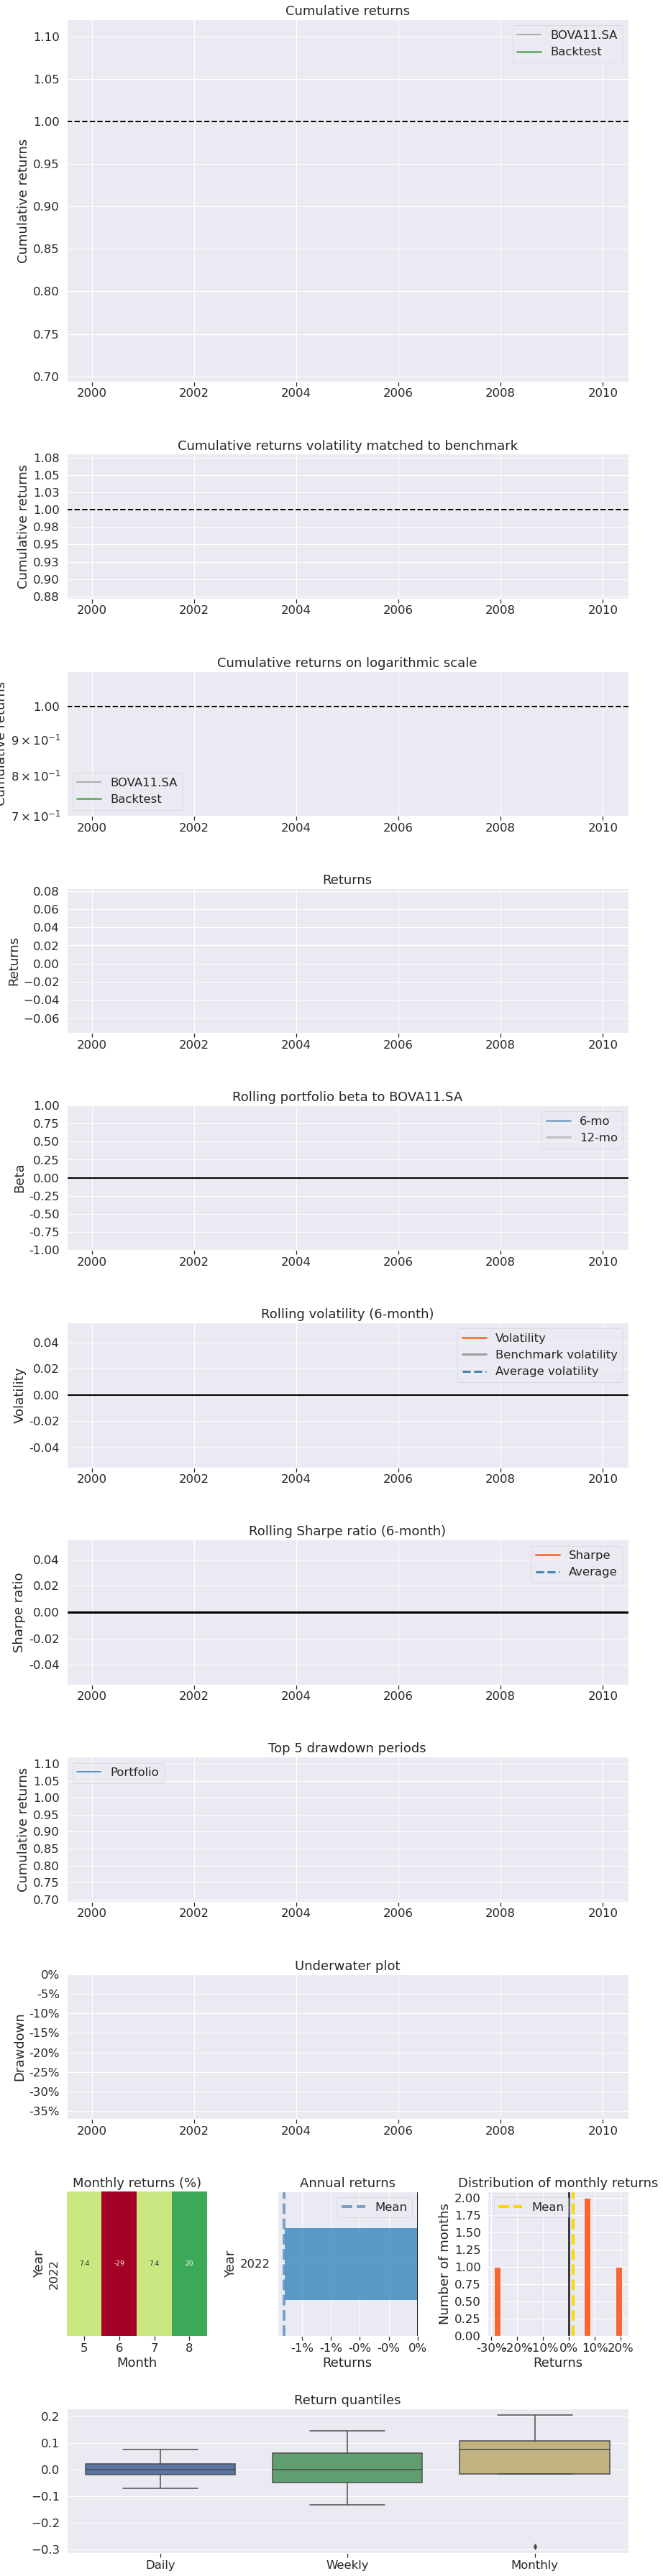

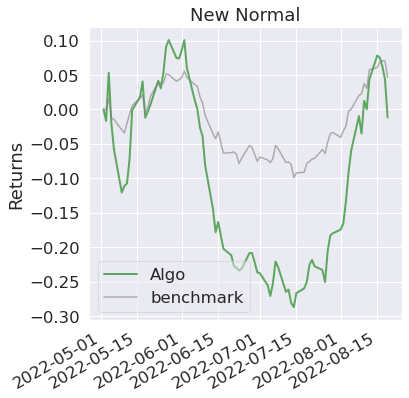

In [32]:
resultado = pf.create_full_tear_sheet(carteira["retorno"], benchmark_rets=benchmark["BOVA11.SA"])

In [ ]:
"""# CALCULO"""

carteira = valor * retorno_acumulado.iloc[:, :len(tickers)-1]
carteira["saldo"] = carteira.sum(axis=1)
carteira["retorno"] = carteira["saldo"].pct_change()
carteira

"""# RESULTADO"""

Resultado = pf.create_full_tear_sheet(carteira["retorno"], benchmark_rets=benchmark["BOVA11.SA"].pct_change())